In [ ]:
import pandas as pd
import numpy as np

**Load Dataset**

In [ ]:
df = pd.read_csv('/content/fraudTrain.csv')
print("Initial Data Shape:", df.shape)

Initial Data Shape: (1296675, 23)


**Drop Unnecessary Columns**

In [ ]:
drop_cols = ['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'trans_num']
df.drop(drop_cols, axis=1, inplace=True, errors='ignore')

**Convert DOB → Age**

In [ ]:
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['age'] = 2025 - df['dob'].dt.year
df.drop('dob', axis=1, inplace=True)

**Extract Time Features**

In [ ]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['transaction_day'] = df['trans_date_trans_time'].dt.day
df.drop('trans_date_trans_time', axis=1, inplace=True)

**Handle Missing Values in Categoricals**

In [ ]:
fill_cols = ['job', 'category', 'merchant', 'city', 'state']
for col in fill_cols:
    df[col] = df[col].fillna('Unknown')

**Label Encoding for Categoricals**

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
cat_cols = ['gender', 'job', 'category', 'merchant', 'city', 'state']
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

**Calculate Distance Between Customer & Merchant**

In [ ]:
def calculate_distance(row):
    try:
        return geodesic((row['lat'], row['long']),
                        (row['merch_lat'], row['merch_long'])).km
    except:
        return 0

In [ ]:
df['distance'] = df.apply(calculate_distance, axis=1)

**Drop raw lat/long columns**

In [ ]:
df.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis=1, inplace=True)

**Separate Labels**

In [ ]:
labels = df['is_fraud']
df.drop('is_fraud', axis=1, inplace=True)

**Standardization**

In [ ]:
from sklearn.preprocessing import  StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [ ]:

print("Scaled Data Shape:", X_scaled.shape)


Scaled Data Shape: (1296675, 14)


**PCA for Dimensionality Reduction**
*Keep 95% variance*

In [ ]:
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
print("PCA Shape (95% variance retained):", X_pca.shape)

PCA Shape (95% variance retained): (1296675, 14)


**For visualization (2D projection)**

In [ ]:
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)

In [ ]:
print("2D PCA Shape:", X_2d.shape)

2D PCA Shape: (1296675, 2)


**Final Checks**

In [ ]:
print("\nFinal Feature Count (post-PCA):", X_pca.shape[1])
print("Fraud cases:", labels.sum())
print("Normal cases:", len(labels) - labels.sum())


Final Feature Count (post-PCA): 14
Fraud cases: 7506
Normal cases: 1289169


**Train Isolation Forest**

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
so = IsolationForest(
    n_estimators=100,
    contamination=0.006,   # expected fraud ratio
    random_state=42
)

In [ ]:
df['anomaly'] = iso.fit_predict(X_pca)

In [ ]:
# Map anomalies: -1 → Fraud, 1 → Normal
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

print("Fraud cases detected (Isolation Forest):", df['anomaly'].sum())
print("Normal cases:", len(df) - df['anomaly'].sum())

Fraud cases detected (Isolation Forest): 7781
Normal cases: 1288894


**Scatter Plot**

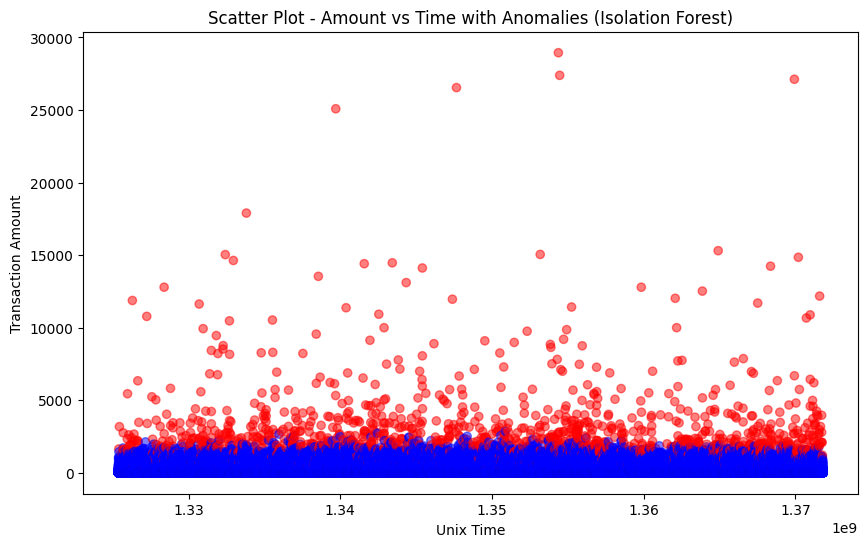

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(
    df['unix_time'], df['amt'],
    c=df['anomaly'].map({0:'blue', 1:'red'}),
    alpha=0.5
)
plt.xlabel("Unix Time")
plt.ylabel("Transaction Amount")
plt.title("Scatter Plot - Amount vs Time with Anomalies (Isolation Forest)")
plt.show()


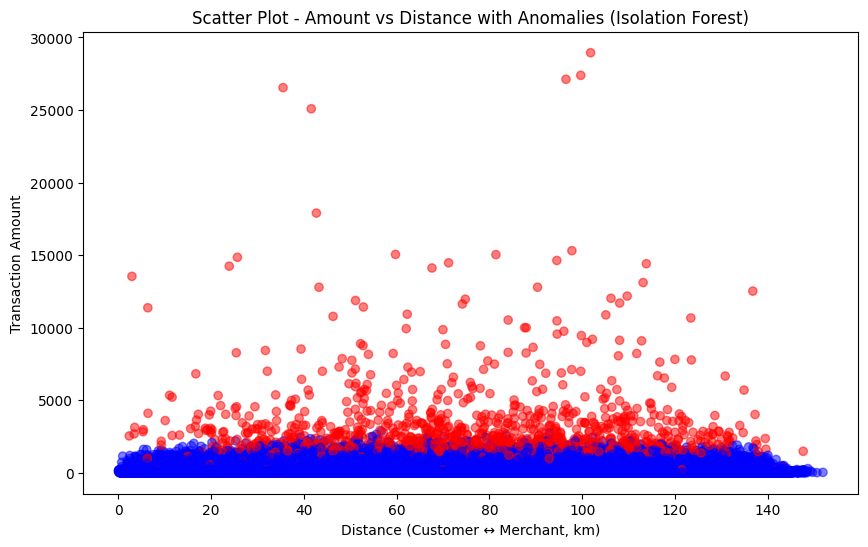

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(
    df['distance'], df['amt'],
    c=df['anomaly'].map({0:'blue', 1:'red'}),
    alpha=0.5
)
plt.xlabel("Distance (Customer ↔ Merchant, km)")
plt.ylabel("Transaction Amount")
plt.title("Scatter Plot - Amount vs Distance with Anomalies (Isolation Forest)")
plt.show()


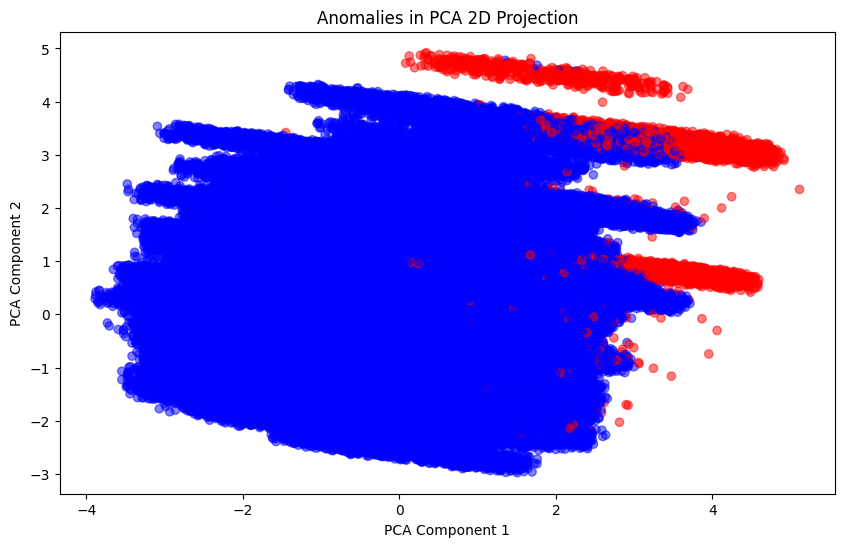

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=df['anomaly'].map({0:'blue', 1:'red'}),
    alpha=0.5
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Anomalies in PCA 2D Projection")
plt.show()


**compare fraud vs non-fraud distributions:**

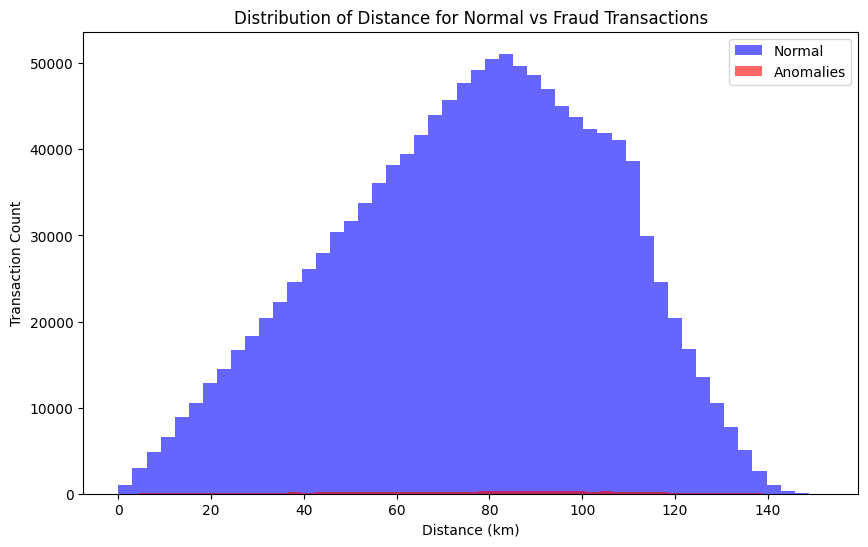

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df[df['anomaly']==0]['distance'], bins=50, alpha=0.6, label="Normal", color="blue")
plt.hist(df[df['anomaly']==1]['distance'], bins=50, alpha=0.6, label="Anomalies", color="red")
plt.xlabel("Distance (km)")
plt.ylabel("Transaction Count")
plt.title("Distribution of Distance for Normal vs Fraud Transactions")
plt.legend()
plt.show()
